In [197]:
def create_imagenet_model(input_shape=(224, 224, 3), num_clinical_features=3, trainable=False):
    """Creates a ResNet50-based binary classification model.

    Parameters:
    - input_shape (tuple, optional): The input shape of the model. Defaults to (224, 224, 3).
    - trainable (bool, optional): Whether the ResNet50 layers should be trainable. Defaults to False.

    Returns:
    - keras.Model: The ResNet50-based binary classification model.
    """
    image_input = layers.Input(input_shape, name='input')
    clinical_input = layers.Input(shape=(num_clinical_features,), name='clinical_input')

#     x = layers.BatchNormalization()(image_input)
    
    # rotation = layers.preprocessing.RandomRotation(factor=(-0.5, 0.5))(image_input)

    resnet = DenseNet121(input_shape=input_shape,
                      include_top=False,
                      weights='imagenet')
    resnet.trainable = trainable

    global_average_layer = layers.GlobalAveragePooling2D()

    x = resnet(image_input, training=trainable)
    x = global_average_layer(x)

    # clin_in = layers.BatchNormalization()(clinical_input)
    concatenated_features = layers.concatenate([x, clinical_input])
#     y = layers.BatchNormalization()(concatenated_features)
    y = layers.BatchNormalization()(concatenated_features)
    y = layers.Dropout(0.3)(y)
#     y = layers.Dense(512, activation='relu')(y)
    # y = layers.Dropout(0.4)(y)
    # y = layers.Dense(32, activation='relu')(y)
    output = layers.Dense(1, activation='linear')(y)
    model = keras.Model(inputs=[image_input, clinical_input], outputs=output)

    # model.layers[1].trainable = trainable

    return model

In [198]:
import time
import tensorflow as tf
import glob
import random
from tensorflow.keras.applications.densenet import preprocess_input
import numpy as np
import os

def extract_identifier(filename):
    # Attempt extraction using both hyphen and underscore separators
    separators = ['-', '_']
    for separator in separators:
        parts = filename.split(separator)
        if len(parts) >= 3:
            identifier = separator.join(parts[:3])
            return identifier
    return None

def _make_riskset(images, clinical_vars, time: np.ndarray, labels_event) -> np.ndarray:
    """Compute mask that represents each sample's risk set.

    Parameters
    ----------
    time : np.ndarray, shape=(n_samples,)
        Observed event time sorted in descending order.

    Returns
    -------
    risk_set : np.ndarray, shape=(n_samples, n_samples)
        Boolean matrix where the `i`-th row denotes the
        risk set of the `i`-th instance, i.e. the indices `j`
        for which the observer time `y_j >= y_i`.
    """
    assert time.ndim == 1, "expected 1D array"

    # sort in descending order
    o = np.argsort(-time, kind="mergesort")
    n_samples = len(time)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = time[i_sort]
        k = i_org
        while k < n_samples and ti == time[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return images, clinical_vars, time, labels_event, risk_set


def _process_batch(images, clinical_vars, labels_time, labels_event, risk_set):
    labels = {
            "label_event": labels_event,
            "label_time": labels_time,
            "label_riskset": risk_set
    }
    return (images, clinical_vars), labels


def prepare_input(tile_path, df):
    raw = tf.io.read_file(tile_path)
    image = tf.io.decode_image(raw)
    image = tf.cast(image, tf.float32)

    image = preprocess_input(image)

    basename = os.path.basename(tile_path)
    id = extract_identifier(basename)
    clinical_vars = df.loc[id][['LVI', 'RTI', 'Size', 'Treatment']]

    labels = df.loc[id][['Time', 'Event']]

    return [np.expand_dims(image, 0), np.expand_dims(clinical_vars, 0)], labels


In [199]:
import pandas as pd

In [200]:
patient_data = pd.read_excel('W:/train_val_cohort.xlsx', header=0, engine="openpyxl").set_index('ID').dropna()

In [201]:
import matplotlib.pyplot as plt

In [202]:
from matplotlib.colors import Normalize

def show_tile(tile):
    tile = np.squeeze(tile)

    norm = Normalize(vmin=tile.min(), vmax=tile.max())
    plt.imshow(norm(tile))
    plt.show()

In [203]:
model = create_imagenet_model(input_shape=(512, 512, 3), num_clinical_features=4, trainable=False)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, 16, 16, 1024)         7037504   ['input[0][0]']               
                                                                                                  
 global_average_pooling2d_1  (None, 1024)                 0         ['densenet121[0][0]']         
  (GlobalAveragePooling2D)                                                                        
                                                                                                  
 clinical_input (InputLayer  [(None, 4)]                  0         []                      

In [204]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, r'C:\Users\093637\Documents\EMC-Seminoma-Relapse\DenseNet121_FSS_10newdl_fold_3', max_to_keep=5)

# Restore the latest checkpoint
latest_checkpoint = checkpoint_manager.latest_checkpoint
if latest_checkpoint:
    checkpoint.restore(latest_checkpoint)
    print(f"Model restored from {latest_checkpoint}")
else:
    print("No checkpoint found. You may need to train the model first.")

Model restored from C:\Users\093637\Documents\EMC-Seminoma-Relapse\DenseNet121_FSS_10newdl_fold_3\ckpt-10


In [10]:
import glob

In [215]:
inp_list_lr = list(glob.glob(r"Y:\Tiles\Tiles-512_10_normalized\TZ_58_F_HE_1\*.png"))[:5]
inp_list_hr = list(glob.glob(r"Y:\Tiles\Tiles-512_10_normalized\TZ_25_C_HE_2\*.png"))[:5]


In [206]:
risk_scores_lr = []
risk_scores_hr = []

for t_p in inp_list_hr:
    input, labels = prepare_input(t_p, patient_data)
    # print(model(input, training=False))
    # show_tile(input[0])

    risk_scores_hr.append(model(input, training=False).numpy()[0][0])

for t_p in inp_list_lr:
    input, labels = prepare_input(t_p, patient_data)
    # print(model(input, training=False))
    # show_tile(input[0])

    risk_scores_lr.append(model(input, training=False).numpy()[0][0])

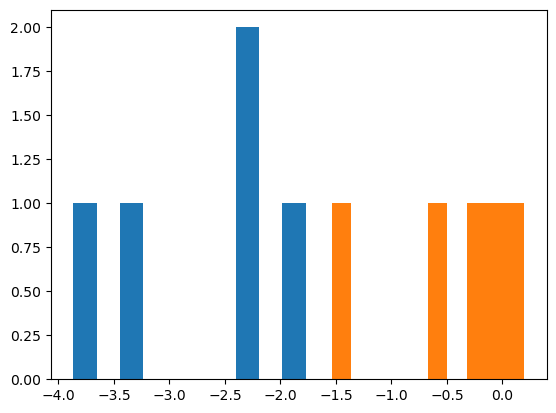

In [207]:
plt.plot()
plt.hist(risk_scores_lr)
plt.hist(risk_scores_hr)
plt.show()

In [217]:
risk_scores_hr

[-0.60008425, -0.0046584764, 0.19617616, -0.27595702, -1.5326753]

In [208]:
np.array(risk_scores_lr).mean()

-2.6972651

In [70]:
np.array(risk_scores_hr).mean()

0.30264986

In [42]:
from sksurv.metrics import concordance_index_censored

In [46]:
patient_data.drop(patient_data.loc[patient_data['Synchronous'] == 1].index, inplace=True)

In [99]:
patient_data.loc[patient_data.loc[patient_data['Event'] == 0].index]

,Event,Time,Synchronous,Treatment,Size,RTI,LVI,Slides
ID,,,,,,,,
TZ_01_IIID,0,87.00,0,0,4.0,0,0,2.0
TZ_06_F,0,46.52,0,0,1.9,0,0,2.0
TZ_07_D,0,82.04,0,1,3.0,1,0,2.0
TZ_10_D,0,92.65,0,0,1.0,0,0,2.0
TZ_11_I-C,0,84.83,0,1,5.5,0,0,2.0
...,...,...,...,...,...,...,...,...
TCGA-ZM-AA0D,0,27.86,0,0,5.0,0,0,1.0
TCGA-ZM-AA0E,0,26.65,0,1,3.0,0,0,1.0
TCGA-ZM-AA0F,0,22.37,0,0,3.9,0,0,1.0


In [49]:
patient_data.iloc[range(22)]

,Event,Time,Synchronous,Treatment,Size,RTI,LVI,Slides
ID,,,,,,,,
TZ_01_IIID,0,87.00,0,0,4.0,0,0,2.0
TZ_06_F,0,46.52,0,0,1.9,0,0,2.0
TZ_07_D,0,82.04,0,1,3.0,1,0,2.0
TZ_10_D,0,92.65,0,0,1.0,0,0,2.0
TZ_11_I-C,0,84.83,0,1,5.5,0,0,2.0
TZ_15_C,0,18.66,0,1,2.1,1,0,2.0
TZ_16_C,0,84.44,0,1,2.0,1,0,2.0
TZ_17_H,0,83.71,0,1,3.6,1,1,2.0
TZ_18_D,0,78.39,0,0,1.9,0,0,2.0


In [223]:
input[1]

array([[0. , 0. , 1.4, 0. ]])

In [219]:
inp_list_hr[50]

'3'

tf.Tensor([[-0.9145762]], shape=(1, 1), dtype=float32)


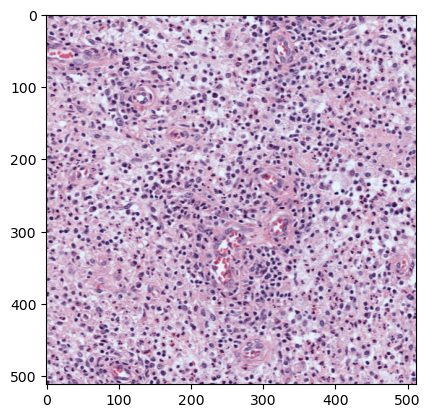

In [225]:
inp_list_hr = list(glob.glob(r"Y:\Tiles\Tiles-512_10_normalized\TZ_33_F_HE_1\*.png"))[:100]

input, labels = prepare_input(inp_list_hr[50], patient_data)
input[1][0][2] = 8
print(model(input, training=False))
show_tile(input[0])

# risk_scores_lr.append(model(input, training=False).numpy()[0][0])

In [185]:
last_conv_layer_name = "conv_pw_13_relu"
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.layers[2].get_layer(model.layers[2].layers[-3].name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [174]:
import cv2

In [186]:
model.layers[-1].activation = None

img_array = input

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()
plt.imshow(tile_test_preproc)
plt.imshow(cv2.resize(heatmap, (512, 512), None), alpha=0.4, cmap='jet')

1/1 [==============================] - 1s 561ms/step


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'") at layer "zero_padding2d". The following previous layers were accessed without issue: []